## Setup

In [67]:
%pip install swifter neuralprophet plotly kaleido statsmodels

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import swifter
import dateutil
import datetime
import kaleido
import plotly
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import KPSSTest, auto_arima
from pmdarima.model_selection import train_test_split

from neuralprophet import NeuralProphet

## Data preparation

### Loading data

In [69]:
df_tribunal = pd.read_csv('dados/processados/serie_temporal_ajuizamento-TJRN_G1_2018.csv', header='infer', sep=';')
print(df_tribunal.head(2))
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(dateutil.parser.parse)
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(datetime.datetime.date)


   Unnamed: 0  numero_processo tribunal  classe_codigo data_ajuizamento  \
0           0     1.002679e+18     TJRN            261       2018-04-23   
1           1     1.004497e+18     TJRN            279       2019-06-20   

   codigo_orgaoJulgador grau  
0                  5981   G1  
1                  5966   G1  


In [70]:
df_tribunal = df_tribunal[df_tribunal['data_ajuizamento'] < '2025-01-01']

In [71]:
dataframe = df_tribunal.groupby(['data_ajuizamento']).size()
df_tribunal = dataframe.to_frame(name='quantidade')
df_tribunal = df_tribunal.rename_axis('data_ajuizamento').reset_index()
print(df_tribunal)

     data_ajuizamento  quantidade
0          2018-01-01           8
1          2018-01-02          73
2          2018-01-03          82
3          2018-01-04         122
4          2018-01-05          12
...               ...         ...
2310       2024-05-03         320
2311       2024-05-04          91
2312       2024-05-05          51
2313       2024-05-06         559
2314       2024-05-07         383

[2315 rows x 2 columns]


In [72]:
#df_tribunal['data_ajuizamento'] = pd.to_datetime(df_tribunal['data_ajuizamento'])

### Visualização dos dados

Série Temporal dos ajuizamentos ao longo do tempo

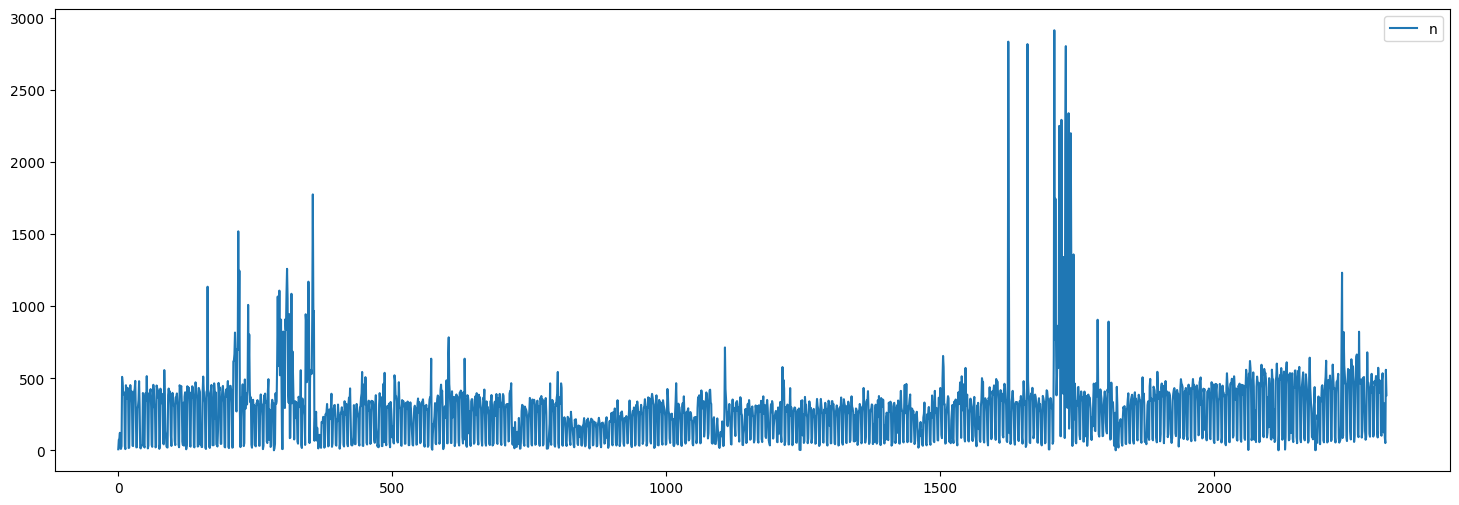

In [73]:
plt.figure(figsize=(18, 6))
plt.plot(df_tribunal['quantidade'])
plt.legend('número de ajuizamentos')

## Análise estatística

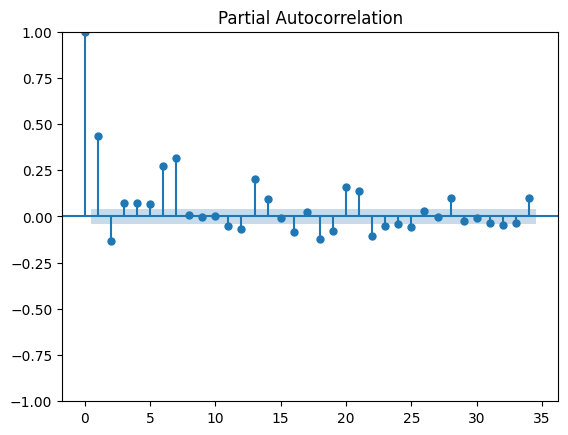

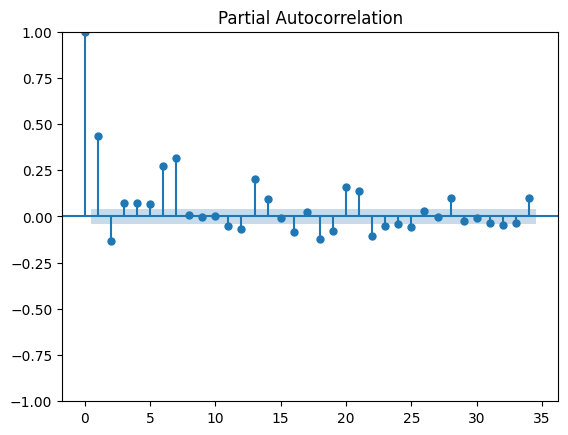

In [74]:
## PACF

df_pacf = df_tribunal
df_pacf.set_index('data_ajuizamento', inplace=True)
plot_pacf(df_pacf)

In [75]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_pacf.quantidade.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

if pval < 0.5:
    print('\n\nA série temporal é estacionária')
else:
    print('\n\nA série temporal não é estacionária')

ADF test statistic: -5.978759473026035
ADF p-values: 1.860132850939429e-07
ADF number of lags used: 27
ADF number of observations: 2287
ADF critical values: {'1%': -3.4332125513481744, '5%': -2.86280460821553, '10%': -2.5674432086780112}
ADF best information criterion: 30320.37777572633


A série temporal é estacionária


# Métodos e modelos

## ARIMA e variantes

In [76]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


In [77]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=5, max_d=2,
            max_q=5, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=15, m=m,
            stepwise=True, trace=True)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]

In [78]:
test_size = 180
m = 30
horizon = 2
ts = df_pacf['quantidade']
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=28827.789, Time=20.94 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=29769.306, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=29652.418, Time=1.31 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=29145.755, Time=4.77 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=29767.308, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=28828.258, Time=12.87 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=28832.230, Time=13.07 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=inf, Time=72.91 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=inf, Time=63.32 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=28858.729, Time=0.65 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=28825.104, Time=45.61 sec
 ARIMA(1,1,2)(0,0,2)[30] intercept   : AIC=28899.715, Time=37.49 sec
 ARIMA(2,1,1)(0,0,2)[30] intercept   : AIC=28863.360, Time=43.62 sec
 ARIMA(3,1,2)(0,0,2)[30] intercept   : AIC=28824.267, Time=72.42 sec
 ARIMA(3

100%|██████████| 181/181 [14:55<00:00,  4.95s/it]


<Axes: xlabel='data_ajuizamento'>

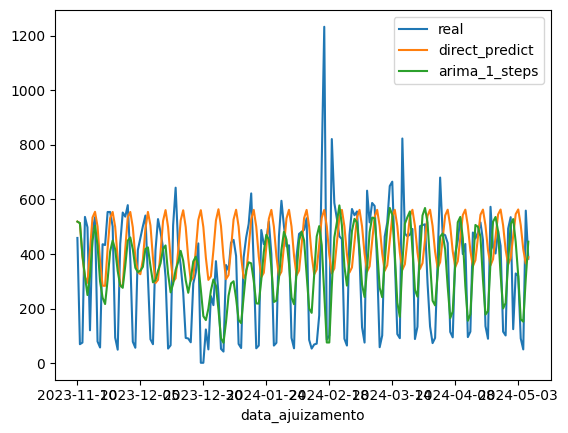

In [79]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()

In [80]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict', 'arima_1_steps']:
  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)
  
pd.DataFrame(metric_results)  

MSE        RMSE        MAPE         MAE      theil       ARV  \
0  64418.167863  253.807344  462.726856  210.692566  11.353203  3.762531   
1  32468.915001  180.191329  211.945687  136.834200   3.725149  2.296945   

       POCID      model_name  
0  52.777778  direct_predict  
1  63.888889   arima_1_steps

## NeuralProphet

In [81]:
dados = pd.DataFrame()
df_tribunal.reset_index(inplace=True)
dados['ds'] = df_tribunal['data_ajuizamento']
dados['y'] = df_tribunal['quantidade']

In [82]:
dados.to_csv('dados/neural_prophet_TJRN_G1_2018.csv', header=True, sep=';', index=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.data.processing._handle_missing_data) - Added 4 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 4 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 4 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.942% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as on

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 4 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 4 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 4 NaN values in column y were auto-imputed.


Predicting: 55it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


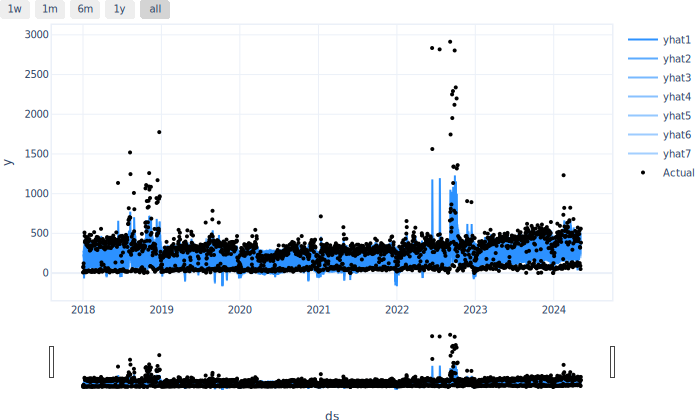

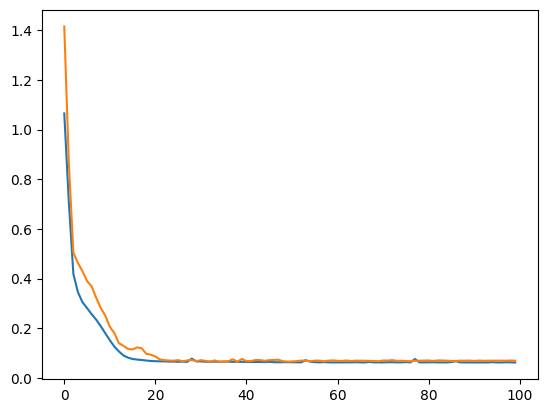

In [83]:
dados = pd.read_csv('dados/neural_prophet_TJRN_G1_2018.csv', header='infer', sep=';')
#dados = dados[dados.y < 6000]
m = NeuralProphet(n_lags=1, n_forecasts=7, ar_layers=(16, 64))
m = m.add_country_holidays("BR")
m.set_plotting_backend("plotly-static")
df_train, df_val = m.split_df(dados, valid_p=0.25)
metrics = m.fit(df_train, validation_df=df_val, freq='D', progress="plot")
forecast = m.predict(dados)
m.plot(forecast)

In [84]:
m.plot_components(forecast)

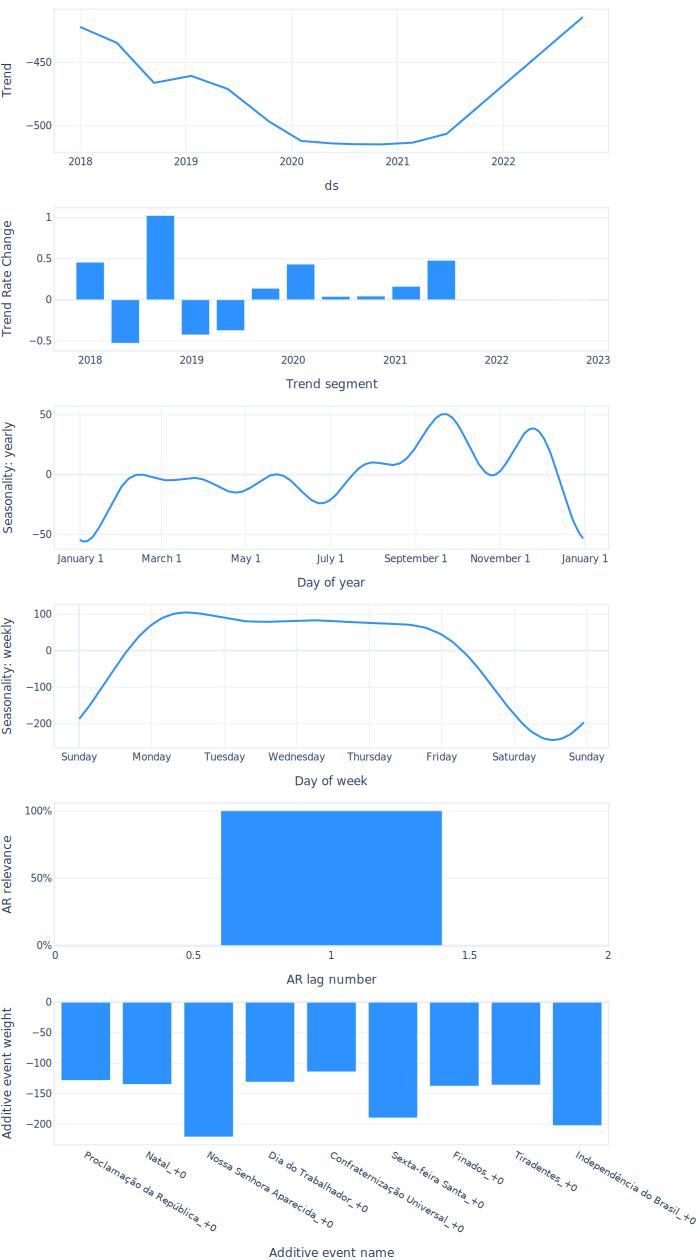

In [85]:
m.plot_parameters()

In [86]:
print(metrics.tail(5))

      MAE_val    RMSE_val  Loss_val  RegLoss_val  epoch        MAE  \
95  79.749939  127.424126  0.068821          0.0     95  79.106026   
96  79.877716  127.556122  0.069028          0.0     96  79.025558   
97  79.604843  127.329491  0.068651          0.0     97  79.449799   
98  80.318382  127.925652  0.069625          0.0     98  79.804047   
99  79.574631  127.328133  0.068633          0.0     99  78.905052   

          RMSE      Loss  RegLoss  
95  180.925674  0.061661      0.0  
96  181.380539  0.061652      0.0  
97  182.204132  0.062612      0.0  
98  183.565384  0.062042      0.0  
99  179.739182  0.061605      0.0  


In [87]:
print(dados['y'].describe())

count    2315.000000
mean      278.441469
std       242.990138
min         1.000000
25%        80.000000
50%       289.000000
75%       376.000000
max      2913.000000
Name: y, dtype: float64


## Prophet

In [88]:
recesso_judiciario = pd.DataFrame({
  'holiday': 'recesso_judiciario',
  'ds': pd.to_datetime(['2018-12-19', '2019-12-19', 
                        '2020-12-19', '2021-12-19',
                        '2022-12-19', '2023-12-19',
                        '2024-12-19', '2025-12-19']),
  'lower_window': 0,
  'upper_window': 18,
})

In [89]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

m = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01,interval_width=0.99, holidays=recesso_judiciario)
m.add_country_holidays(country_name='BR')
m.fit(dados)
df_cv = cross_validation(m, initial='1080 days', period='60 days', horizon = '180 days', parallel="processes")

df_p = performance_metrics(df_cv)
df_p.head(5)

20:42:11 - cmdstanpy - INFO - Chain [1] start processing
20:42:11 - cmdstanpy - INFO - Chain [1] done processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:14 - cmdstanpy - INFO - Chain [1] done processing
20:42:14 - cmdstanpy - INFO - Chain [1] done processing
20:42:14 - cmdstanpy - INFO - Chain

horizon           mse        rmse         mae      mape     mdape     smape  \
0 18 days  86171.487540  293.549804  118.169108  0.774799  0.215080  0.390711   
1 19 days  78944.897972  280.971347  115.305542  0.772020  0.227550  0.388589   
2 20 days  63563.336026  252.117703  110.163590  0.778096  0.236875  0.388404   
3 21 days  71970.937750  268.273998  116.289926  0.783877  0.249062  0.394353   
4 22 days  66048.513688  256.999054  114.820040  0.762497  0.249678  0.394742   

   coverage  
0  0.966184  
1  0.969289  
2  0.972050  
3  0.969289  
4  0.969289

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1081562/481289654.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




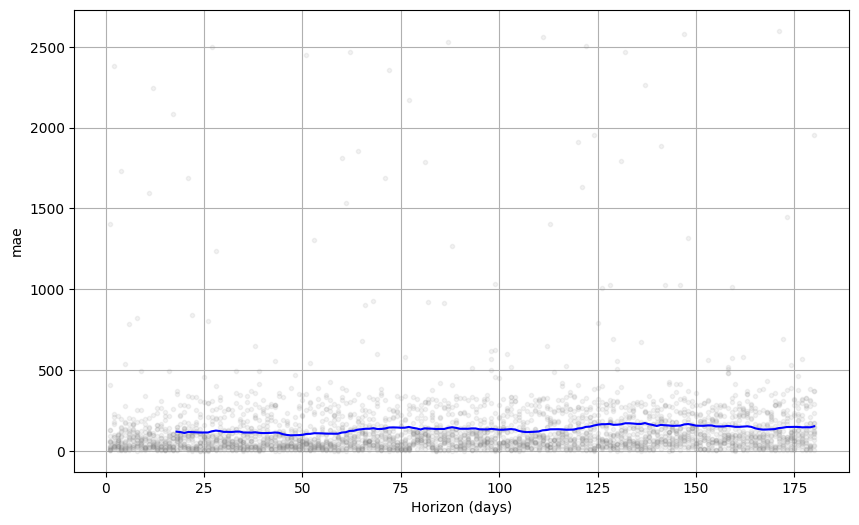

In [90]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig.show()